## Import libraries required for analysis

In [1]:
# NBVAL_IGNORE_OUTPUT
# ^this is a magic comment to work around this issue https://github.com/ebmdatalab/custom-docker/issues/10
from change_detection import functions as chg
from ebmdatalab import bq
from lib.outliers import *  #This is copied into the local folder from a branch ebmdatalab pandas library - it will be placed in its own repo to install at a later dat

## Run change detection for the 3 OpenPrescribing opioid measures
- looks for changes in time-series data
- as described in https://www.bmj.com/content/367/bmj.l5205

In [2]:
# NBVAL_IGNORE_OUTPUT
# ^this is a magic comment to work around this issue https://github.com/ebmdatalab/custom-docker/issues/10
opioids_class = chg.ChangeDetection('practice_data_opioid%',
                                    measure=True,
                                    direction='down',
                                    overwrite=False,
                                    verbose=False,
                                    draw_figures='no')
opioids_class.run()

Using cached data


## Import results of change detection

In [3]:
opioids = opioids_class.concatenate_outputs()
opioids.head()

is.nbreak  is.tfirst  is.tfirst.pknown  \
measure                 name                                             
practice_data_opioidome A81001  0         NaN        NaN                 
                        A81002  0         NaN        NaN                 
                        A81004  0         NaN        NaN                 
                        A81005  0         NaN        NaN                 
                        A81006  1          inf        inf                

                                is.tfirst.pknown.offs  is.tfirst.offs  \
measure                 name                                            
practice_data_opioidome A81001 NaN                    NaN               
                        A81002 NaN                    NaN               
                        A81004 NaN                    NaN               
                        A81005 NaN                    NaN               
                        A81006  inf                    inf              

                                is.tfirst.big  is.slope.ma  is.slope.ma.prop  \
measure                 name                                                   
practice_data_opioidome A81001 NaN            NaN          NaN                 
                        A81002 NaN            NaN          NaN                 
                        A81004 NaN            NaN          NaN                 
                        A81005 NaN            NaN          NaN                 
                        A81006 NaN            NaN          NaN                 

                                is.slope.ma.prop.lev  is.intlev.initlev  \
measure                 name                                              
practice_data_opioidome A81001 NaN                   NaN                  
                        A81002 NaN                   NaN                  
                        A81004 NaN                   NaN                  
                        A81005 NaN                   NaN                  
                        A81006 NaN                   NaN                  

                                is.intlev.finallev  is.intlev.levd  \
measure                 name                                         
practice_data_opioidome A81001 NaN                 NaN               
                        A81002 NaN                 NaN               
                        A81004 NaN                 NaN               
                        A81005 NaN                 NaN               
                        A81006  50330.014139       NaN               

                                is.intlev.levdprop  
measure                 name                        
practice_data_opioidome A81001 NaN                  
                        A81002 NaN                  
                        A81004 NaN                  
                        A81005 NaN                  
                        A81006 NaN

### Get list to filter out closed practices

In [4]:
query = """
SELECT
  DISTINCT code
FROM
  ebmdatalab.hscic.practices
WHERE
  status_code = "A"
"""
open_practices = bq.cached_read(query,csv_path='data/open_practices.csv')
open_practices.head()

,code
0,W94609
1,W94622
2,W95036
3,A99915
4,A99960


In [5]:
open_practices.size

11474

### Get practices with a small list size to filter them out 

In [6]:
query = """
SELECT
  DISTINCT practice
FROM
  ebmdatalab.hscic.practice_statistics
WHERE
  total_list_size < 2000
"""
small_list_size = bq.cached_read(query,csv_path='data/small_list_size.csv')
small_list_size.head()

,practice
0,Y00031
1,Y00613
2,Y02313
3,Y02797
4,Y02926


In [7]:
small_list_size.size

2105

### Remove small list sizes and closed/dormant practices

In [8]:
opioids_saved = opioids

In [12]:
opioids.index.get_level_values(0).unique()

Index(['practice_data_opioidome', 'practice_data_opioidper1000',
       'practice_data_opioidspercent'],
      dtype='object', name='measure')

In [18]:
#print(len(opioids))
print(f"practice_data_opioidome: {len(opioids.loc['practice_data_opioidome',:])}")
print(f"practice_data_opioidper1000: {len(opioids.loc['practice_data_opioidper1000',:])}")
print(f"practice_data_opioidspercent: {len(opioids.loc['practice_data_opioidspercent',:])}")

practice_data_opioidome: 12390
practice_data_opioidper1000: 12275
practice_data_opioidspercent: 12191


In [23]:

mask = opioids.index.get_level_values(1).isin(open_practices['code'])
print( f"Number of open practices (from input file): {open_practices.size}" )
print( f"Number of practices that we identify as open (practice_data_opioidome): {len(opioids[mask].loc['practice_data_opioidome',:])}" )
print( f"Number of practices that we identify as open (practice_data_opioidper1000): {len(opioids[mask].loc['practice_data_opioidper1000',:])}" )
print( f"Number of practices that we identify as open (practice_data_opioidspercent): {len(opioids[mask].loc['practice_data_opioidspercent',:])}" )


Number of open practices (from input file): 11474
Number of practices that we identify as open (practice_data_opioidome): 11264
Number of practices that we identify as open (practice_data_opioidper1000): 11170
Number of practices that we identify as open (practice_data_opioidspercent): 11147


In [24]:
opioids = opioids.loc[mask]
#print(len(opioids))


In [25]:
mask = opioids.index.get_level_values(1).isin(small_list_size['practice'])
print( f"Number of small practices (from input file): {small_list_size.size}" )
print( f"Number of practices that we identify as open AND with a small list size (practice_data_opioidome): {len(opioids[~mask].loc['practice_data_opioidome',:])}" )
print( f"Number of practices that we identify as open AND with a small list size (practice_data_opioidper1000): {len(opioids[~mask].loc['practice_data_opioidper1000',:])}" )
print( f"Number of practices that we identify as open AND with a small list size (practice_data_opioidspercent): {len(opioids[~mask].loc['practice_data_opioidspercent',:])}" )

opioids = opioids.loc[~mask]


Number of small practices (from input file): 2105
Number of practices that we identify as open AND with a small list size (practice_data_opioidome): 10869
Number of practices that we identify as open AND with a small list size (practice_data_opioidper1000): 10812
Number of practices that we identify as open AND with a small list size (practice_data_opioidspercent): 10803


In [30]:
#print(len(opioids))
#opioids.head()

In [30]:
len(opioids.loc["practice_data_opioidome",:])

10869

# Results
These are filtered:
- to only include practices that started within the highest 20% of all practices
- to remove any practices that have a short sudden spike that would lead the change detection algorithm to detect a sudden drop

and then sorted according to the largest total measured drop.

## Total Oral Morphine Equivalence
https://openprescribing.net/measure/opioidome

,Month when change detected,Measured proportional change,plots
link,,,
VALENTINE MEDICAL CENTRE,2018-06-01,0.736706,
MP VICTORIA MILL,2018-09-01,0.619678,
WESTERN AVE MEDICAL CTRE,2017-02-01,0.610835,
THE WEAVERHAM SURGERY,2017-09-01,0.591525,
3/SPRINGFIELD HOUSE MEDICAL PRACTICE,2016-12-01,0.561731,
PADDOCK AND LONGWOOD FAMILY PRACTICE,2017-05-01,0.545953,
WEST HEATH SURGERY,2015-11-01,0.536242,
QUEEN STREET SURGERY,2017-08-01,0.525459,
SHAFTESBURY MEDICAL CTR.,2017-08-01,0.521498,

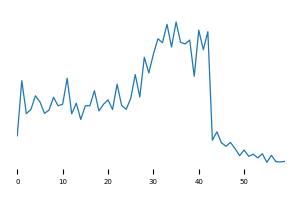
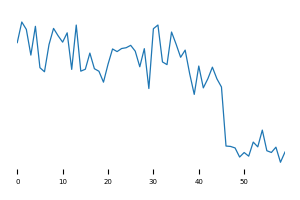
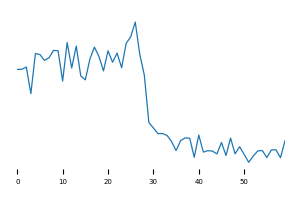
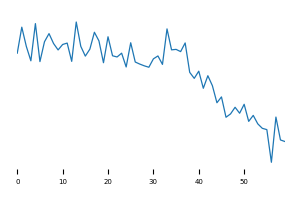
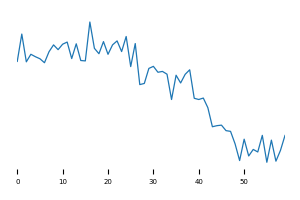
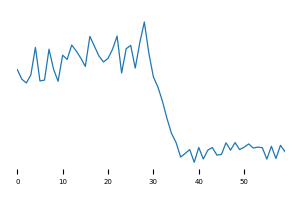
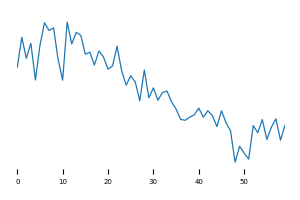
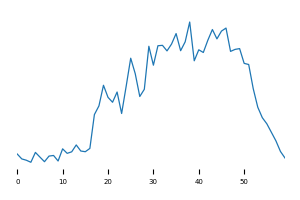
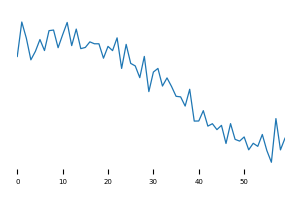
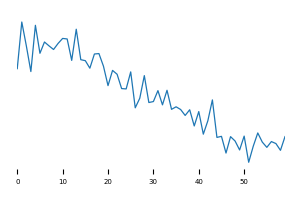

In [7]:
filtered_sparkline(opioids,
                   'practice_data_opioid/practice_data_opioidome',
                   'practice_data_opioidome')

## High dose opioids as percentage regular opioids

https://openprescribing.net/measure/opioidspercent

In [27]:
filtered_sparkline(opioids,
                   'practice_data_opioid/practice_data_opioidspercent',
                   'practice_data_opioidspercent')

30

## High dose opioids per 1000 patients

https://openprescribing.net/measure/opioidper1000

,Month when change detected,Measured proportional change,plots
link,,,
CRANESWATER GROUP PRACTICE,2017-08-01,0.972216,
WILLENHAL OAK MEDICAL CENTRE,2018-02-01,0.968600,
3/SPRINGFIELD HOUSE MEDICAL PRACTICE,2018-02-01,0.951970,
QUEEN STREET SURGERY,2018-08-01,0.932033,
HOPWOOD MEDICAL CENTRE,2018-09-01,0.925599,
DR VARDHAN'S SURGERY,2017-06-01,0.905956,
HUNTLEY MOUNT MEDICAL CENTRE,2017-07-01,0.890936,
CRAMLINGTON MEDICAL GROUP,2017-01-01,0.890191,
PENNINGTON PARK SURGERY,2017-11-01,0.884191,

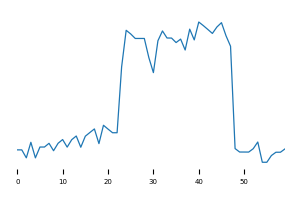
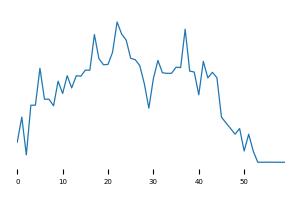
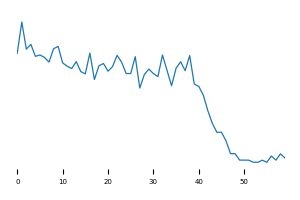
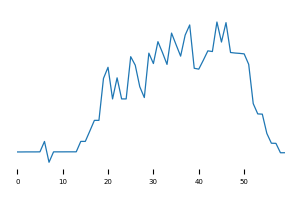
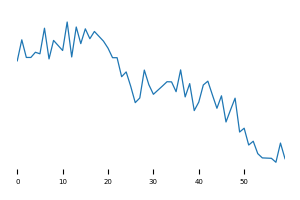
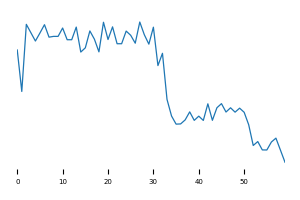
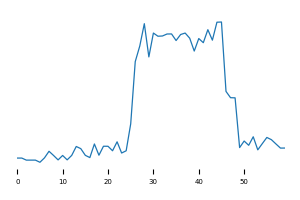
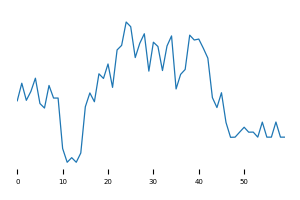
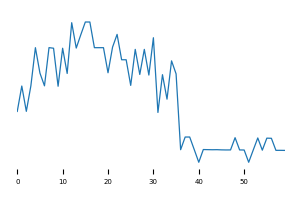
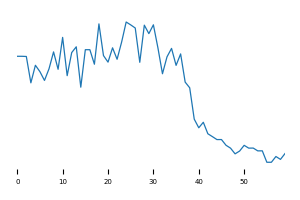

In [9]:
filtered_sparkline(opioids,
                   'practice_data_opioid/practice_data_opioidper1000',
                   'practice_data_opioidper1000')